In [1]:
# Code write by Aurelle TCHAGNA, tkaurelle@gmail.com

In [16]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [19]:
# load the dataset
dataframe = read_csv('2_cell_4g_peak.csv', usecols=[5], engine='python', skiprows=[0])
dataset = dataframe.values
dataset = dataset.astype('float32')
dataframe.head(3)

,
0,16.97778
1,16.22222
2,66.03333


In [20]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [21]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [22]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1, activation='sigmoid', name='foo'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
foo (Dense)                  (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [24]:
from livelossplot import PlotLossesKeras

In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')
#history = model.fit(trainX, trainY, epochs=10, batch_size=4, verbose=2)


In [26]:
history = model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), batch_size=4, verbose=2,)

Train on 105150 samples, validate on 26285 samples
Epoch 1/100
 - 34s - loss: 0.0080 - val_loss: 0.0068
Epoch 2/100
 - 38s - loss: 0.0064 - val_loss: 0.0067
Epoch 3/100
 - 39s - loss: 0.0064 - val_loss: 0.0067
Epoch 4/100
 - 38s - loss: 0.0064 - val_loss: 0.0067
Epoch 5/100
 - 39s - loss: 0.0063 - val_loss: 0.0067
Epoch 6/100
 - 41s - loss: 0.0063 - val_loss: 0.0067
Epoch 7/100
 - 38s - loss: 0.0063 - val_loss: 0.0067
Epoch 8/100
 - 39s - loss: 0.0063 - val_loss: 0.0067
Epoch 9/100
 - 39s - loss: 0.0063 - val_loss: 0.0067
Epoch 10/100
 - 39s - loss: 0.0063 - val_loss: 0.0066
Epoch 11/100
 - 38s - loss: 0.0063 - val_loss: 0.0067
Epoch 12/100
 - 41s - loss: 0.0063 - val_loss: 0.0067
Epoch 13/100
 - 38s - loss: 0.0063 - val_loss: 0.0067
Epoch 14/100
 - 39s - loss: 0.0063 - val_loss: 0.0067
Epoch 15/100
 - 39s - loss: 0.0063 - val_loss: 0.0066
Epoch 16/100
 - 38s - loss: 0.0063 - val_loss: 0.0067
Epoch 17/100
 - 38s - loss: 0.0063 - val_loss: 0.0066
Epoch 18/100
 - 39s - loss: 0.0063 - val

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


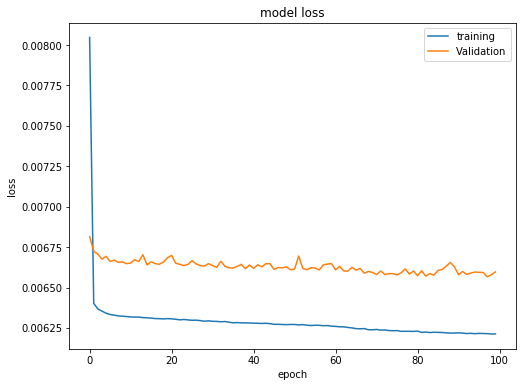

In [28]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'Validation'])
plt.show()

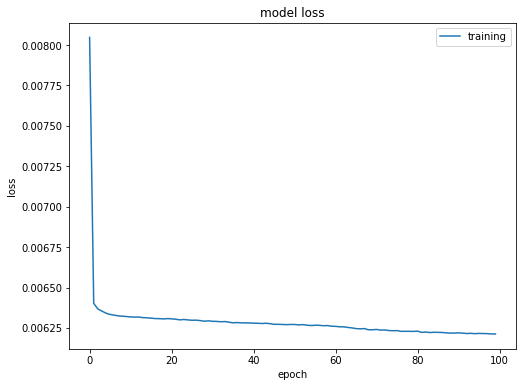

In [29]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training'])
plt.show()

In [33]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [34]:
#Frasconi Model
from keras.layers import Dense, Flatten
modelF = Sequential()
modelF.add(Flatten(input_shape=(look_back, 1)))
modelF.add(RBFLayer(10, 0.5))
modelF.add(Dense(1, activation='sigmoid', name='foo'))
#model.compile(optimizer='rmsprop', loss=binary_crossentropy)
modelF.compile(loss='mean_squared_error',optimizer='adam')
historyF = modelF.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), batch_size=4, verbose=2,)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 105150 samples, validate on 26285 samples
Epoch 1/100
 - 20s - loss: 0.0077 - val_loss: 0.0074
Epoch 2/100
 - 21s - loss: 0.0070 - val_loss: 0.0073
Epoch 3/100
 - 17s - loss: 0.0069 - val_loss: 0.0072
Epoch 4/100
 - 17s - loss: 0.0069 - val_loss: 0.0072
Epoch 5/100
 - 17s - loss: 0.0068 - val_loss: 0.0071
Epoch 6/100
 - 17s - loss: 0.0068 - val_loss: 0.0071
Epoch 7/100
 - 17s - loss: 0.0068 - val_loss: 0.0071
Epoch 8/100
 - 17s - loss: 0.0067 - val_loss: 0.0071
Epoch 9/100
 - 17s - loss: 0.0067 - val_loss: 0.0070
Epoch 10/100
 - 17s - loss: 0.0067 - val_loss: 0.0070
Epoch 11/100
 - 18s - loss: 0.0067 - val_loss: 0.0071
Epoch 12/100
 - 17s - loss: 0.0067 - val_loss: 0.0070
Epoch 13/100
 - 17s - loss: 0.0066 - val_loss: 0.0070
Epoch 14/100
 - 17s - loss: 0.0066 - val_loss: 0.0070
Epoch 15/100
 - 17s - loss: 0.0066 - val_loss: 0.0070
Epoch 16/100
 - 17s - loss: 0.0066 - val_loss: 0.0070


In [36]:
print(historyF.history.keys())

dict_keys(['val_loss', 'loss'])


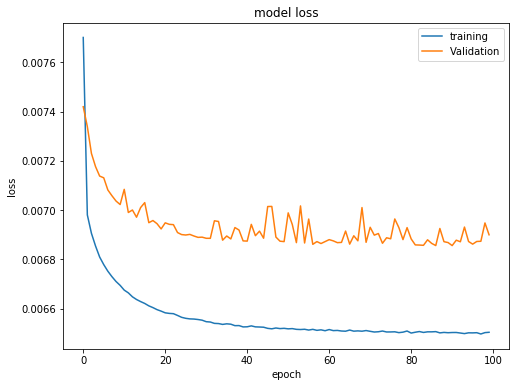

In [37]:
figure(figsize=(8, 6))
plt.plot(historyF.history['loss'])
plt.plot(historyF.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'Validation'])
plt.show()

In [39]:
# Jordan Model
# Define a network as a linear stack of layers
modelJ = Sequential()

# Add a recurrent layer with 2 units
modelJ.add(SimpleRNN(1, input_shape=(look_back, 1)))

# Add the output layer with a sigmoid activation
modelJ.add(Dense(1, activation='tanh'))
modelJ.summary()
modelJ.compile(loss='mean_squared_error',optimizer='adam')
historyJ = modelJ.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), batch_size=4, verbose=2,)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Train on 105150 samples, validate on 26285 samples
Epoch 1/100
 - 33s - loss: 0.0070 - val_loss: 0.0068
Epoch 2/100
 - 34s - loss: 0.0065 - val_loss: 0.0067
Epoch 3/100
 - 31s - loss: 0.0064 - val_loss: 0.0067
Epoch 4/100
 - 31s - loss: 0.0064 - val_loss: 0.0067
Epoch 5/100
 - 32s - loss: 0.0064 - val_loss: 0.0067
Epoch 6/100
 - 31s - loss: 0.0064 - val_loss: 0.0067
Epoch 7/100
 - 32s - loss: 0.0064 - val_loss: 0.0067
Epoch 8/100
 - 32s - loss: 0.0064 - val_loss: 0.0067
Epoch 9/100
 - 32s - loss: 0.0064 - val_loss: 0

dict_keys(['val_loss', 'loss'])


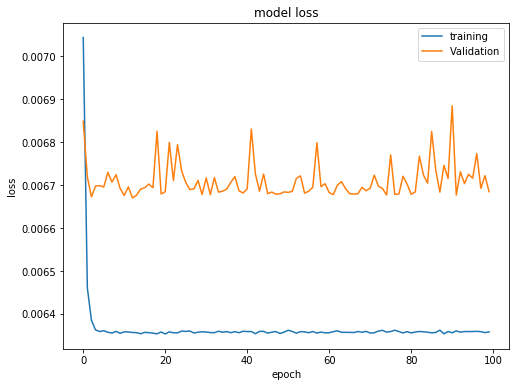

In [40]:
print(historyJ.history.keys())
figure(figsize=(8, 6))
plt.plot(historyJ.history['loss'])
plt.plot(historyJ.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'Validation'])
plt.show()

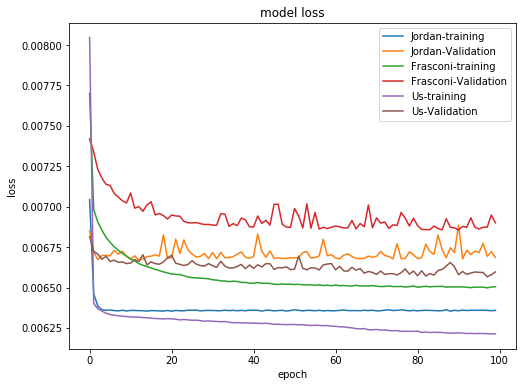

In [46]:
#SUpperposition des Plot
figure(figsize=(8, 6))
plt.plot(historyJ.history['loss'])
plt.plot(historyJ.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['Jordan-training', 'Jordan-Validation'])
plt.plot(historyF.history['loss'])
plt.plot(historyF.history['val_loss'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Jordan-training', 'Jordan-Validation','Frasconi-training', 'Frasconi-Validation','Us-training', 'Us-Validation'])
plt.show()

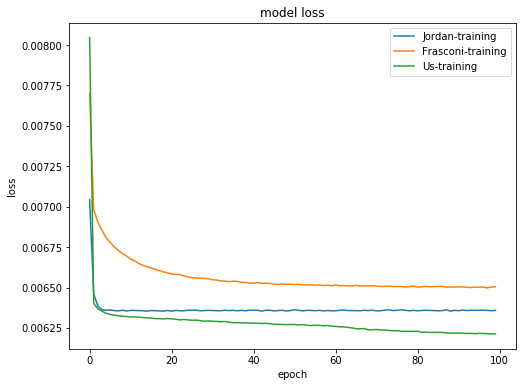

In [47]:
#SUpperposition des Plot
figure(figsize=(8, 6))
plt.plot(historyJ.history['loss'])
#plt.plot(historyJ.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['Jordan-training', 'Jordan-Validation'])
plt.plot(historyF.history['loss'])
#plt.plot(historyF.history['val_loss'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.legend(['Jordan-training', 'Frasconi-training','Us-training',])
plt.show()

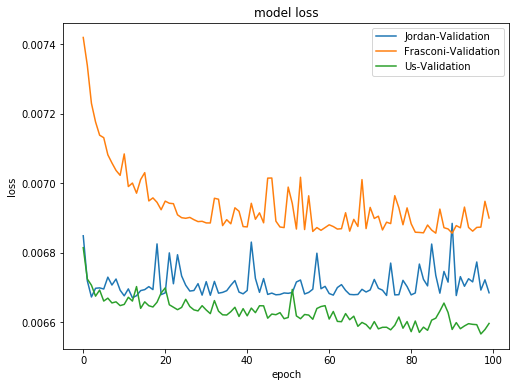

In [48]:
#SUpperposition des Plot
figure(figsize=(8, 6))
#plt.plot(historyJ.history['loss'])
plt.plot(historyJ.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['Jordan-training', 'Jordan-Validation'])
#plt.plot(historyF.history['loss'])
plt.plot(historyF.history['val_loss'])
#plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend([ 'Jordan-Validation', 'Frasconi-Validation', 'Us-Validation'])
plt.show()

In [49]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [50]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [51]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.74 RMSE
Test Score: 14.17 RMSE


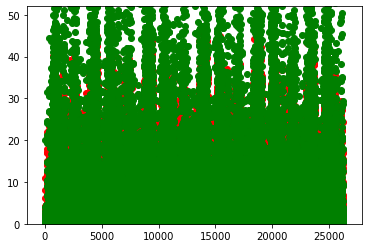

In [17]:
plt.scatter(range(26285),testPredict,c='r')
plt.scatter(range(26285),testY,c='g')
plt.ylim([0, 52])
plt.show()


In [ ]:
plt.scatter(range(26285),testPredict,c='r')
plt.show()

In [ ]:
plt.scatter(range(26285),testY,c='g')
plt.ylim([0, 52])
plt.show()

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [ ]:
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
# calculate root mean squared error
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))